# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

import pandas as pd

import rede_escolar

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 11/Jul/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

In [6]:
bairros_fino = np.load('geoloc_Bairros_MRJ_Fino.npy')

In [7]:
def refina_matriz(matriz, filtro):
    '''
    Refina uma matriz via interpolação linear e uma matriz fina como filtro.  
    '''
    matriz_fina = np.zeros_like(filtro)
    loc_sobra = list() 
    
    tx_refinamento_x = int(filtro.shape[1]/matriz.shape[1])
    tx_refinamento_y = int(filtro.shape[0]/matriz.shape[0])
    xs = list(range(matriz.shape[1]))
    ys = list(range(matriz.shape[0]))

    xs_fino = np.arange(0, matriz.shape[1], 1/tx_refinamento_x)
    ys_fino = np.arange(0, matriz.shape[0], 1/tx_refinamento_y)

    f = interp2d(xs, ys, matriz, kind='linear')
    matriz_interp = f(xs_fino, ys_fino)*np.minimum(filtro,1)

    for j in xs:
        for i in ys:
            if matriz[i,j]:
                matriz_interp_local \
                    = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x]
                if matriz_interp_local.sum() == 0:
                    loc_sobra.append([i,j])
                else:
                    distrib = np.floor(matriz[i,j]*matriz_interp_local
                                           / matriz_interp_local.sum()
                                      ).astype('int')
                    sobra = matriz[i,j] - distrib.sum()
                    sobra_posicionamento \
                        = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                           int(sobra),
                                           replace=False,
                                           p=(matriz_interp_local
                                              /matriz_interp_local.sum()
                                             ).flatten()
                                          )
                    for loc in sobra_posicionamento:
                        distrib[loc // tx_refinamento_x,
                                loc % tx_refinamento_x] += 1
                    matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x] \
                        = distrib

    matriz_sobra = np.zeros_like(matriz)
    for ij in loc_sobra:
        matriz_sobra[ij[0], ij[1]] = matriz[ij[0], ij[1]]
    
    return matriz_fina, matriz_sobra

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [80]:
modalidades = [2,3,5,6,7,15,21,30,35,42,105,210]
escolas_pub = np.array([np.load(f'mtrx_escolas/escolas_publicas_{m}.npy') for m in modalidades])
escolas_prv = np.array([np.load(f'mtrx_escolas/escolas_privadas_{m}.npy') for m in modalidades])

Por enquanto não faremos distinção entre a escola ser pública ou privada, para isto somaremos as duas matrizes

In [81]:
escolas = escolas_pub + escolas_prv

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [11]:
tx_reducao = 100

In [12]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/tx_reducao).astype(int)

### Distribuindo e alocando os indivíduos e as suas residências

In [13]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 454 ms, sys: 0 ns, total: 454 ms
Wall time: 456 ms


## Rede escolar

Na construção da rede escolar, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas

- Para alocar a população nas escolas: Calculamos a distância de cada individuo para todas as escolas, e tomamos as 3 escolas mais próximas. Feito isso é selecionao uma das 3 escolas de maneira aleatória

- Para o cenário múltiplo de `Pop350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

In [284]:
def reducao_escolas(tx_reducao, mtrx_escolas):
    """Função que faz a redução da quantidade de escolas em dado Heatmap

    Args:
        tx_reducao (float): A taxa de redução a qual esta submetido o cenário.
        mtrx_escolas (array): Array que contém as matrizes/heatmaps da distribuição das escolas por 
        modadlidade, também pode ser passado somente uma matriz.

    Returns:
        array: Array de matrizes/heatmaps reduzidos
    """
    
    ## Caso a taxa de redução seja 1, não fazer nada
    if tx_reducao == 1:
        return mtrx_escolas
    else:
        ## Caso seja passado somente um heatmap, ao inves de uma lista de heatmaps
        ## Transforma em uma lista unitária de heatmap
        if len(mtrx_escolas.shape) < 3:
            mtrx_escolas = np.array([mtrx_escolas])
        total_escolas = np.sum(mtrx_escolas)
        rng = np.arange(np.prod(mtrx_escolas[0].shape))
        ## Para cada modalidade, a quantidade de escolas reduzidas
        qt_modalidade = map(lambda x: np.rint(np.sum(x)/tx_reducao).astype(int), mtrx_escolas)
        ## Faz uma escolha aleatória com pesos nos blocos do heatmap de cada modalidade
        pesos_modalidade = map(lambda x: (x/np.sum(x)).flatten(), mtrx_escolas)
        modalidade_reduzidas = map(lambda x,y: random.choices(rng, x, k = y), pesos_modalidade, qt_modalidade)

        ## Preenchemos, para cada modalidade, os blocos sorteados
        mtrx_reduzida = np.zeros(mtrx_escolas.shape)
        for i,m in enumerate(modalidade_reduzidas):
            m = np.array(m)
            row_escolas = np.floor(m/mtrx_escolas.shape[-1])
            col_escolas = np.mod(m,mtrx_escolas.shape[-1])
            for k,j in zip(row_escolas,col_escolas):
                mtrx_reduzida[i][int(k)][j] += 1
        return mtrx_reduzida

In [283]:
%%time
escolas_reduzida = reducao_escolas(tx_reducao, escolas)

CPU times: user 9.62 ms, sys: 0 ns, total: 9.62 ms
Wall time: 8.89 ms


Fazendo a interpolação para o refinamento da malha

In [114]:
mtrx_escolas_reduzida = np.array([refina_matriz(i, bairros_fino)[0] for i in mtrx_escolas_reduzida])

#### Heatmaps das escolas por modalidade - cenário completo

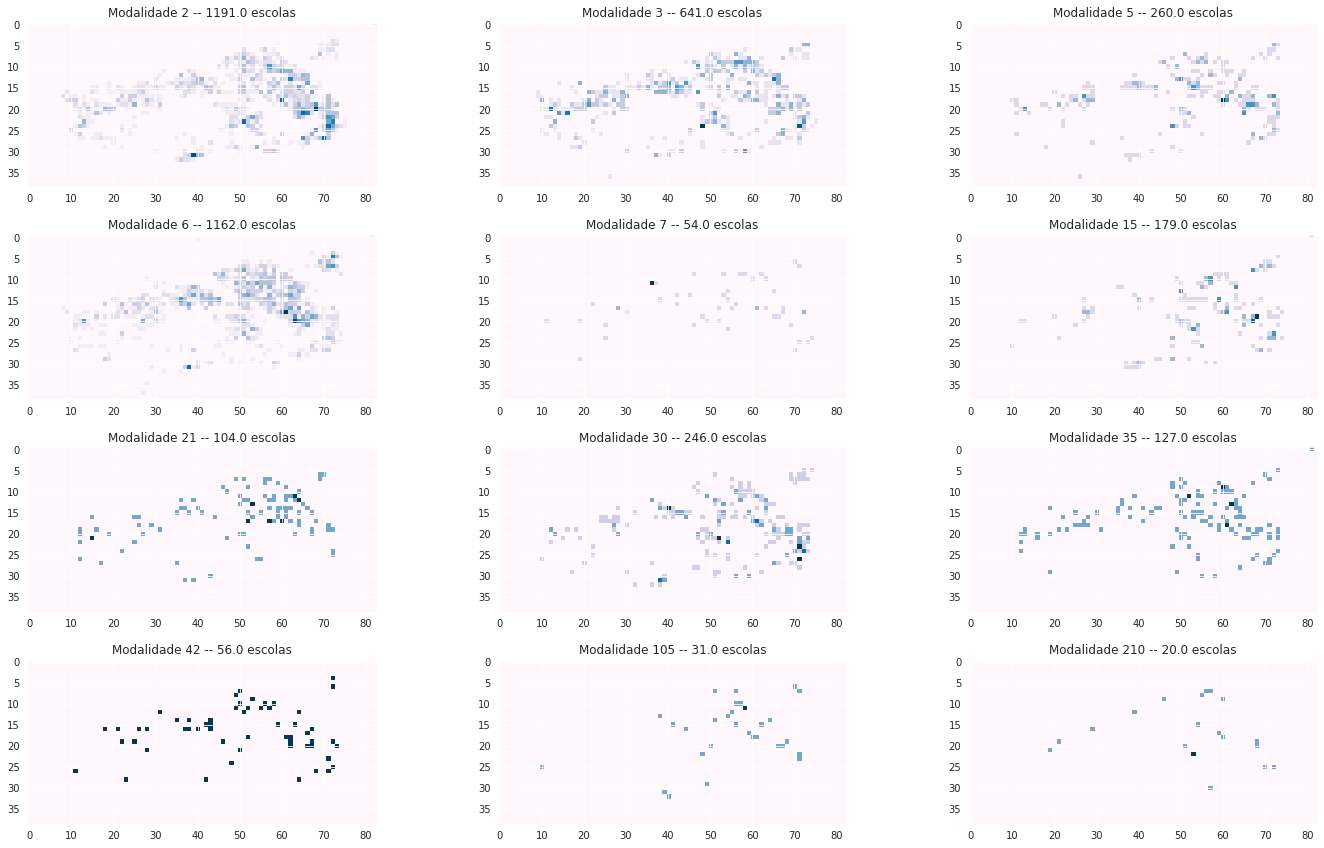

Total de 4071.0 escolas


In [206]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (20,12))

for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.imshow(escolas[j+3*i], cmap = 'PuBu')
        col.set_title(f'Modalidade {modalidades[j+3*i]} -- {np.sum(escolas[j+3*i])} escolas')
fig.tight_layout(pad=1.5)
plt.show()
print(f'Total de {np.sum(escolas)} escolas')

#### Heatmaps das escolas por modalidade - cenário reduzido

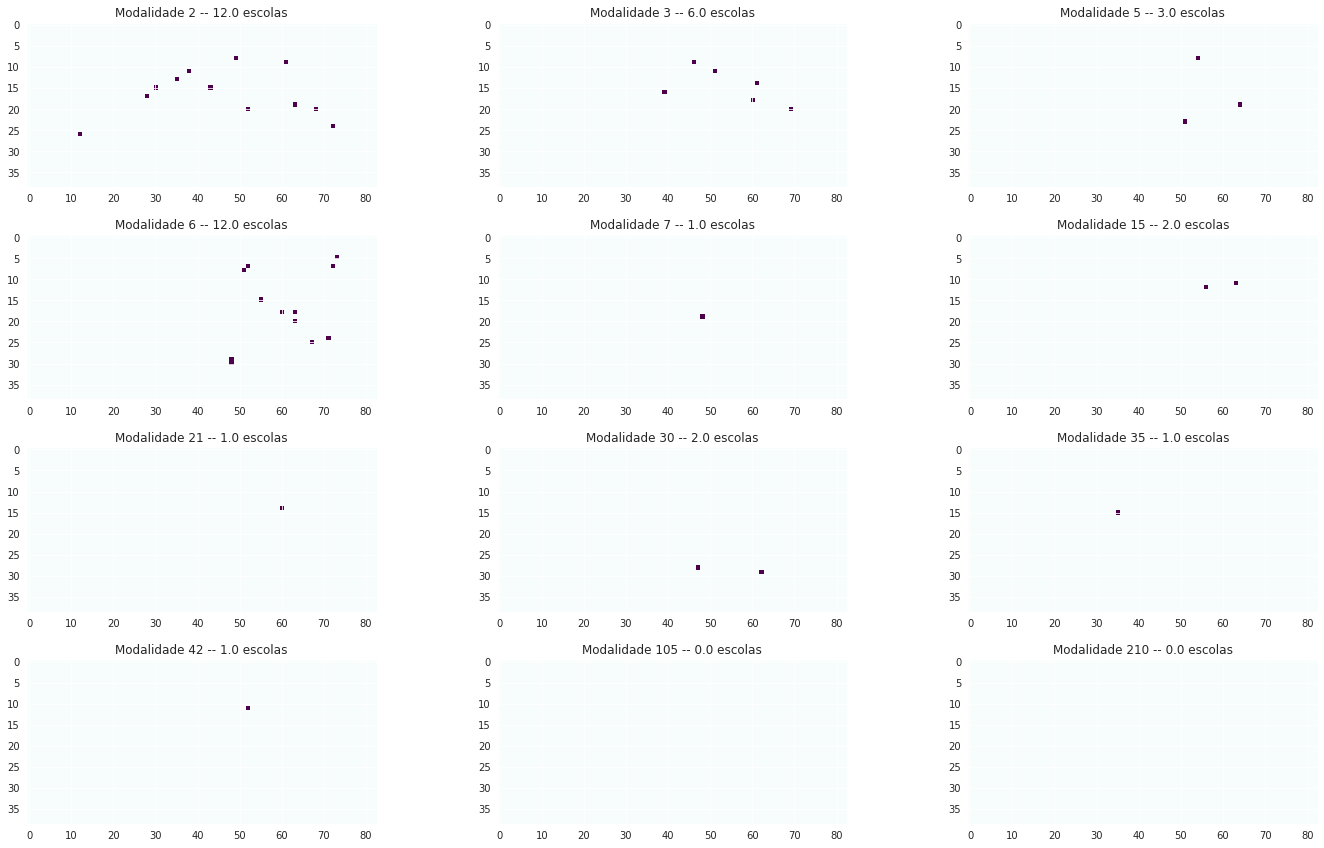

Total de 41.0 escolas, utilizando uma taxa de redução de 100


In [285]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (20,12))

for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.imshow(escolas_reduzida[j+3*i], cmap = 'BuPu')
        col.set_title(f'Modalidade {modalidades[j+3*i]} -- {np.sum(escolas_reduzida[j+3*i])} escolas')
fig.tight_layout(pad=1.5)
plt.show()
print(f'Total de {np.sum(escolas_reduzida)} escolas, utilizando uma taxa de redução de {tx_reducao}')

### Gerando a distribuição de idade da população

In [219]:
num_pop = pop_por_blocos.sum()

piramide_etaria = pd.read_csv('../../../../dados/RJ/cidade_rj/dados_estatisticos/piramide_etaria_MRJ.csv')
idades_grupos = np.array([int(p[0:2]) for p in piramide_etaria.columns[1:]])
idades_grupos[-1] = 100
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 99
pop_idades = episiming.cenarios.gera_idades(len(pos_individuos), 8, res_individuos, idades_grupos, idades_fracoes_grupos, idade_max = 100)

In [701]:
def dist_idade_modalidade(idade_max, grupos_idade_escolar, dist_grupos_idade):
    """Função que calcula a quantidade de matriculas por idade e modalidade escolar, segundo censo

    Args:
        idade_max (int): Idade max da população do cenário
        grupos_idade_escolar (array): Array com a separação de idades por grupo, onde cada par de elementos
        representa um intervalo do tipo [a,b)
        dist_grupos_idade (array): Array com a distribuição de cada grupo de idades, segundo censo.
        Pode ser passado apenas um array com a distribuição, ou um array de arrays com distribuição
        que representa a distribuição por modalidades

    Returns:
        array: Array com matrizes de tamanho 100, representando a quantidade total de cada idade de aluno em 
        uma modalidade
    """
    
    ## Caso seja passado somente um array em dist_grupos_idade
    if len(dist_grupos_idade.shape) < 2:
        dist_grupos_idade = np.array([dist_grupos_idade])
    
    ## Matriz com a distribuição de idade, separado idade a idade
    dist_idade = np.zeros((len(dist_grupos_idade),idade_max))
    
    ## Transforma a informação de distribuição por grupo de idade para distribuição por idade
    for j in range(len(dist_grupos_idade)):
        for i in range(len(grupos_idade_escolar)):
            if i < len(dist_grupos_idade[j]):
                dist_idade[j][grupos_idade_escolar[i]:grupos_idade_escolar[i+1]] = dist_grupos_idade[j][i]
                
    ## Calcula a quantidade de alunos na idade, por modalidade
    dist_idade_pop = np.array([np.count_nonzero(pop_idades == i) for i in range(idade_max)])
    dist_idade_escolar = np.round(dist_idade[:grupos_idade_escolar[-2]]*dist_idade_pop)
    return dist_idade_escolar

In [708]:
grupos = np.array([0, 4, 6, 15, 20, 100])

In [337]:
fracoes_grupos_2 = np.array([0.14666667, 0.40888889, 0.        , 0.        , 0.        ])
fracoes_grupos_3 = np.array([0.        , 0.        , 0.25569862, 0.        , 0.        ])
fracoes_grupos_5 = np.array([0.        , 0.        , 0.        , 0.23945578, 0.        ])
fracoes_grupos_6 = np.array([0.14346756, 0.39997017, 0.45939074, 0.        , 0.        ])
fracoes_grupos_7 = np.array([0.        , 0.        , 0.        , 0.        , 0.00673317])
fracoes_grupos_15 = np.array([0.        , 0.        , 0.07249391, 0.16689342, 0.        ])
fracoes_grupos_21 = np.array([0.        , 0.        , 0.04097482, 0.        , 0.01296758])
fracoes_grupos_30 = np.array([0.0303915 , 0.08472782, 0.09731519, 0.22403628, 0.        ])
fracoes_grupos_35 = np.array([0.        , 0.        , 0.        , 0.11882086, 0.01633416])
fracoes_grupos_42 = np.array([0.00689038, 0.01920955, 0.02206336, 0.        , 0.00698254])
fracoes_grupos_105 = np.array([0.        , 0.        , 0.0137896 , 0.03174603, 0.00436409])
fracoes_grupos_210 = np.array([0.00258389, 0.00720358, 0.00827376, 0.01904762, 0.00261845])

fracoes_grupos = np.array([fracoes_grupos_2,fracoes_grupos_3,fracoes_grupos_5,fracoes_grupos_6,fracoes_grupos_7,
                          fracoes_grupos_15,fracoes_grupos_21,fracoes_grupos_30,fracoes_grupos_35,fracoes_grupos_42,
                          fracoes_grupos_105,fracoes_grupos_210])

In [702]:
%%time
qt_idade_modalidade = dist_idade_modalidade(idade_max, grupos, fracoes_grupos)

CPU times: user 4.01 ms, sys: 17 µs, total: 4.03 ms
Wall time: 3.33 ms


In [686]:
def escolhe_alunos_idade(pop_idades, idades_na_escola):
    """Função que escolhe uma quantidade de individuos na população, pela idade, para serem matriculados
    em alguma escola

    Args:
        pop_idades (list(int)): Uma lista da idade de cada invididuo na população
        idades_escola (list(int)): Uma lista com a distribuição de alunos por idade

    Returns:
        array: Array com os indices dos alunos na população, separados pela distribuição de idade
    """
    alunos_modalidade = []
    for j in range(len(idades_na_escola)):
        alunos = np.array([np.random.permutation(np.arange(len(pop_idades))[pop_idades == i][:int(idades_na_escola[j][i])]) for i in range(len(idades_na_escola[j]))])
        alunos_modalidade.append(alunos)
    return alunos_modalidade

In [707]:
%%time
alunos = escolhe_alunos_idade(pop_idades, qt_idade_modalidade)

CPU times: user 120 ms, sys: 28 µs, total: 120 ms
Wall time: 120 ms


In [799]:
def gera_pos_escolas(mtrx_escolas):
    pos_escolas_modalidade = []
    rng = np.arange(np.prod(mtrx_escolas[0].shape))
    for m in mtrx_escolas:
        qt_por_pos = m[m > 0].astype(int)
        pos = rng[m.flatten() > 0]
        aux = []
        for p,q in zip(pos,qt_por_pos):
            for i in range(q):
                aux.append((np.mod(p,m.shape[1]), p//m.shape[1]))
        pos_escolas_modalidade.append(aux)
    return pos_escolas_modalidade

In [802]:
pos_escolas_modalidade = gera_pos_escolas(mtrx_escolas_reduzida)

In [828]:
pos_escolas_modalidade

[[(693, 70),
  (693, 70),
  (693, 70),
  (571, 81),
  (386, 141),
  (625, 142),
  (643, 154),
  (678, 164),
  (270, 168),
  (630, 200),
  (133, 201),
  (370, 261),
  (660, 281),
  (399, 310)],
 [(196, 140), (405, 154), (591, 170), (485, 204), (127, 241), (480, 248)],
 [(557, 84), (367, 159), (380, 316)],
 [(560, 75),
  (551, 122),
  (523, 150),
  (431, 153),
  (367, 156),
  (660, 203),
  (647, 206),
  (532, 228),
  (222, 235),
  (390, 270),
  (427, 304),
  (277, 372)],
 [(253, 217)],
 [(714, 64), (294, 180)],
 [(171, 272)],
 [(161, 192), (474, 208)],
 [(555, 179)],
 [(720, 46)],
 [],
 []]

In [806]:
np.hstack(alunos[0])

array([ 6744,  3906,  6018, ...,  3467, 25867,  3304])

In [947]:
def aloca_alunos(alunos, pos_escolas, pos_individuos):
    matriculas_modalidade = [[ [] for _ in range(len(p))] for p in pos_escolas]
    for i in range(len(alunos)):

        alunos_modalidade = np.hstack(alunos[i])
        pos_alunos_modalidade = np.array(pos_individuos)[alunos_modalidade]
        dist_aluno_esc = [np.linalg.norm(p_i - pos_escolas[i], axis = 1).argsort()[:3] for p_i in pos_alunos_modalidade if len(pos_escolas[i]) > 0]
        matricula = [random.choices(k)[0] for k in dist_aluno_esc]
        for k in range(len(matricula)):
            matriculas_modalidade[i][matricula[k]].append(alunos_modalidade[k])
            
    return matriculas_modalidade

In [940]:
len(np.hstack(alunos[0]))

1124

In [948]:
l = aloca_alunos(alunos, pos_escolas_modalidade, pos_individuos)